Predicting on Liver CT_Scans

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Model raw prediction shape: (1, 128, 128, 1)
Prediction mask shape after sigmoid and squeeze: (128, 128)
Tumor probability (mean over mask): 0.5001457


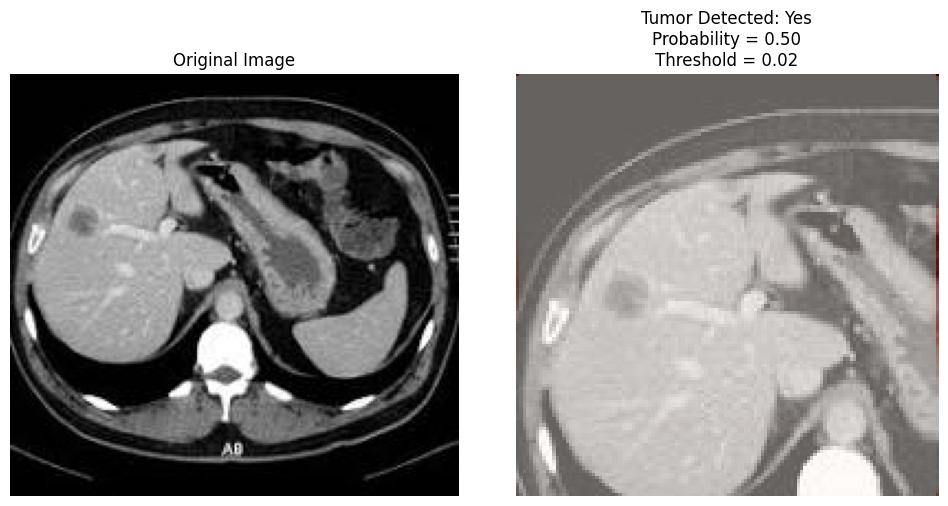

Number of connected components detected: 1
Centroid of the largest tumor region: (63.510425108671626, 64.22154276873204)
Converted centroid to pixel coordinates: (64, 63)


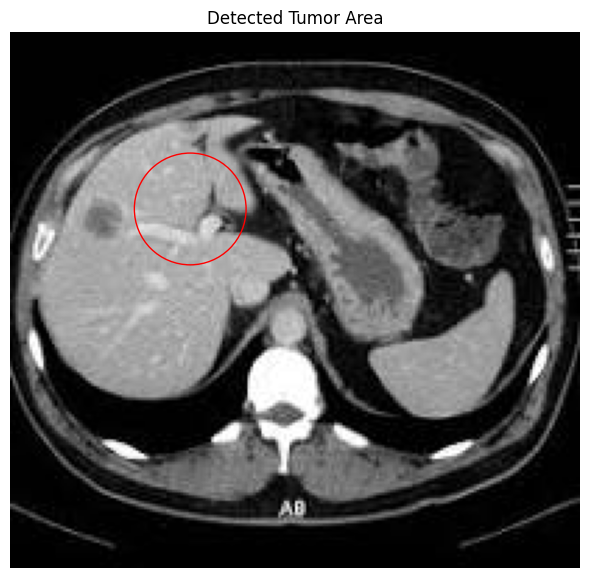

In [58]:
# Import necessary libraries
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


# Load the trained U-Net model
model = load_model('best_unet_model.keras')


# Preprocessing function
def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess the input image for U-Net model.
    Resize, convert to grayscale, and normalize pixel values.
    """
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    resized_image = image.resize(target_size)  # Resize to the input size of the model
    image_array = np.array(resized_image) / 255.0  # Normalize pixel values to range [0, 1]
    image_array = image_array.reshape(1, target_size[0], target_size[1], 1)  # Reshape for model input
    return image_array


# Function to predict using the U-Net model
def predict_segmentation(image_array, model):
    """
    Predict using the U-Net model and generate the segmentation mask.
    Also applies sigmoid activation if the model's predictions aren't probabilistic yet.
    """
    prediction = model.predict(image_array)  # Predict segmentation map
    print("Model raw prediction shape:", prediction.shape)  # Debugging
    prediction_mask = 1 / (1 + np.exp(-prediction))  # Apply sigmoid
    prediction_mask = np.squeeze(prediction_mask)  # Remove batch and channel dimensions
    print("Prediction mask shape after sigmoid and squeeze:", prediction_mask.shape)  # Debugging
    return prediction_mask


# Function to find tumor centroid and draw a circle on the largest tumor area
def find_and_draw_tumor_region(original_image, prediction_mask):
    """
    Analyze the segmentation mask to find the tumor's centroid and draw a circular marker around it.
    :param original_image: The original input image as a NumPy array.
    :param prediction_mask: The segmentation mask output from the U-Net model.
    :return: The coordinates of the centroid and the modified image with a circular overlay.
    """
    # Threshold the mask for binary segmentation (assuming predictions are probabilities)
    binary_mask = prediction_mask > 0.5  # A simple threshold for binary detection

    # Find connected components
    labeled_mask, num_features = ndimage.label(binary_mask)  # Label connected regions
    print("Number of connected components detected:", num_features)  # Debugging

    if num_features == 0:
        print("No tumor regions detected.")
        return None, original_image

    # Find the largest connected region by area
    sizes = ndimage.sum(binary_mask, labels=labeled_mask, index=np.arange(num_features + 1))
    largest_region_idx = sizes.argmax()  # Index of the largest region
    largest_region_mask = labeled_mask == largest_region_idx

    # Calculate the centroid of the largest region
    centroid = ndimage.center_of_mass(largest_region_mask)
    print("Centroid of the largest tumor region:", centroid)  # Debugging

    # Convert the centroid from normalized to pixel coordinates
    centroid_coords = (int(centroid[1]), int(centroid[0]))  # (x, y) format
    print("Converted centroid to pixel coordinates:", centroid_coords)

    # Draw a circle on the original image (centered at the computed centroid)
    radius = 20  # Radius of the circle
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(original_image, cmap="gray")
    if centroid_coords:
        circle = plt.Circle((centroid_coords[0], centroid_coords[1]), radius, color='red', fill=False)
        ax.add_artist(circle)
    ax.set_title("Detected Tumor Area")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    return centroid_coords, original_image


# Function to visualize the results
def visualize_results(image_path, original_image, prediction_mask, tumor_probability, tumor_detected, threshold):
    """
    Visualize the original image, prediction mask, and tumor detection results.
    Also overlays the prediction mask and shows detection information.
    """
    # Normalize the prediction mask values robustly to range [0, 1]
    normalized_mask = (prediction_mask - prediction_mask.min()) / max(prediction_mask.max() - prediction_mask.min(), 1e-5)

    # Create subplots for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    ax1.imshow(original_image, cmap='gray')
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Overlay the normalized prediction mask on the original image with controlled transparency
    ax2.imshow(original_image, cmap='gray')
    ax2.imshow(normalized_mask, cmap='Reds', alpha=0.4)
    ax2.set_title(
        f"Tumor Detected: {'Yes' if tumor_detected else 'No'}\nProbability = {tumor_probability:.2f}\nThreshold = {threshold}"
    )
    ax2.axis('off')

    # Display visualization
    plt.tight_layout()
    plt.show()


# Main pipeline to process, predict, and visualize
def process_and_predict(image_path, model, threshold):
    """
    Full pipeline to preprocess image, predict using U-Net, visualize tumor detection,
    and optionally draw the circular tumor area.
    """
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Predict the segmentation map
    raw_prediction_mask = predict_segmentation(image_array, model)

    # Calculate the tumor detection probability
    tumor_probability = np.mean(raw_prediction_mask)  # Average probability over the predicted mask
    print("Tumor probability (mean over mask):", tumor_probability)
    tumor_detected = tumor_probability > threshold

    # Load the original image for visualization purposes
    original_image = Image.open(image_path).convert("L")

    # Visualize the prediction results
    visualize_results(image_path, original_image, raw_prediction_mask, tumor_probability, tumor_detected, threshold)

    # Find and draw the tumor area
    find_and_draw_tumor_region(np.array(original_image), raw_prediction_mask)


# Path to the uploaded image
uploaded_image_path = '/content/download.jpg'

# Set the adjustable probability threshold manually
probability_threshold = 0.02  # Manually adjustable value (default is 0.02)

# Predict and visualize the results
process_and_predict(uploaded_image_path, model, threshold=probability_threshold)
